# 1. Load data from SQL

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
import pandas as pd
import os
from dotenv import load_dotenv


In [2]:
# 
conn = psycopg2.connect(
	dbname="precipitation_data",
	user="hoangbaoan1901",
	password="cglkdr12345",
	host="localhost",
)

cursor = conn.cursor()
cursor.execute("SELECT version();")

db_version = cursor.fetchone()
print("PostgreSQL version:", db_version)

PostgreSQL version: ('PostgreSQL 15.10 (Debian 15.10-0+deb12u1) on x86_64-pc-linux-gnu, compiled by gcc (Debian 12.2.0-14) 12.2.0, 64-bit',)


In [3]:
query = """
select * from weather_data 
where
	row = 68
    and
    col = 114
    and 
    extract(month from date) = 4;
"""

df = pd.read_sql_query(query, conn)
cursor.close()
conn.close()

/tmp/ipykernel_22824/566495779.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [4]:
df.head()

,date,row,col,radar,aws,imerge,tclw,cape,v250,ie,...,b10b,i4b,b11b,i2b,b09b,b04b,vsb,b16b,b05b,irb
0,2019-04-01 00:00:00,68,114,0.0,0.0,0.0,0.225830,759.125,5.113296,NaN,...,257.45880,290.28372,282.82080,278.85460,249.03088,0.104350,0.088053,264.52820,0.104492,284.63092
1,2019-04-01 01:00:00,68,114,0.0,NaN,0.0,0.204163,723.500,5.680862,NaN,...,260.68770,299.10953,287.69766,287.09180,251.23914,0.173376,0.158496,272.24637,0.181966,290.69235
2,2019-04-01 02:00:00,68,114,0.0,0.0,0.0,0.213501,917.125,6.107910,NaN,...,260.56412,303.87555,285.81708,285.59586,251.51646,0.360067,0.296783,271.52182,0.332662,288.76926
3,2019-04-01 03:00:00,68,114,0.0,0.0,0.0,0.272217,1738.500,6.348114,NaN,...,262.32440,305.31427,289.77900,288.07953,253.34952,0.365930,0.233643,272.90450,0.318176,292.46332
4,2019-04-01 04:00:00,68,114,0.0,0.0,0.0,0.233093,2944.875,6.519119,NaN,...,262.08865,304.72775,287.47437,285.91275,253.72750,0.447479,0.333323,271.70470,0.337891,290.04220


In [5]:
df.shape

(1440, 40)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 40 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1440 non-null   datetime64[ns]
 1   row     1440 non-null   int64         
 2   col     1440 non-null   int64         
 3   radar   1266 non-null   float64       
 4   aws     1413 non-null   float64       
 5   imerge  1440 non-null   float64       
 6   tclw    1440 non-null   float64       
 7   cape    1440 non-null   float64       
 8   v250    1172 non-null   float64       
 9   ie      182 non-null    float64       
 10  r850    1440 non-null   float64       
 11  u850    974 non-null    float64       
 12  tcwv    1440 non-null   float64       
 13  tcw     1440 non-null   float64       
 14  sshf    518 non-null    float64       
 15  isor    1440 non-null   float64       
 16  kx      1440 non-null   float64       
 17  ewss    697 non-null    float64       
 18  r250    

# 2. Filter & create training data

In [7]:
# Set date as pandas datetime & as index
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df = df.sort_index()
df.head()	

,row,col,radar,aws,imerge,tclw,cape,v250,ie,r850,...,b10b,i4b,b11b,i2b,b09b,b04b,vsb,b16b,b05b,irb
date,,,,,,,,,,,,,,,,,,,,,
2019-04-01 00:00:00,68,114,0.0,0.0,0.0,0.225830,759.125,5.113296,NaN,83.97984,...,257.45880,290.28372,282.82080,278.85460,249.03088,0.104350,0.088053,264.52820,0.104492,284.63092
2019-04-01 01:00:00,68,114,0.0,NaN,0.0,0.204163,723.500,5.680862,NaN,82.85120,...,260.68770,299.10953,287.69766,287.09180,251.23914,0.173376,0.158496,272.24637,0.181966,290.69235
2019-04-01 02:00:00,68,114,0.0,0.0,0.0,0.213501,917.125,6.107910,NaN,87.04326,...,260.56412,303.87555,285.81708,285.59586,251.51646,0.360067,0.296783,271.52182,0.332662,288.76926
2019-04-01 03:00:00,68,114,0.0,0.0,0.0,0.272217,1738.500,6.348114,NaN,90.82649,...,262.32440,305.31427,289.77900,288.07953,253.34952,0.365930,0.233643,272.90450,0.318176,292.46332
2019-04-01 04:00:00,68,114,0.0,0.0,0.0,0.233093,2944.875,6.519119,NaN,91.00833,...,262.08865,304.72775,287.47437,285.91275,253.72750,0.447479,0.333323,271.70470,0.337891,290.04220


In [8]:
X = []
y = []

for i in range(len(df) - 1):
	current_row = df.iloc[i]
	next_row = df.iloc[i + 1]
	
	# Because 'date' is index, use `row.name` to get the index
	if next_row.name == current_row.name + pd.Timedelta(hours=1) and not pd.isnull(next_row['aws']):
		X.append(current_row.values)
		y.append(next_row['aws'])

# Convert X and y to pandas DataFrames
X = pd.DataFrame(X, columns=df.columns)
y = pd.DataFrame(y, columns=['aws'])

print(X.shape)
print(y.shape)

# Drop 'row' and 'col' columns
drop_columns = ['row', 'col']
X = X.drop(columns=drop_columns)
# Remove index from X and y
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

(1411, 39)
(1411, 1)


In [9]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(1128, 37)
(283, 37)
(1128, 1)
(283, 1)


# 3. Random Forest Regressor

In [10]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE: 0.8464944598988654


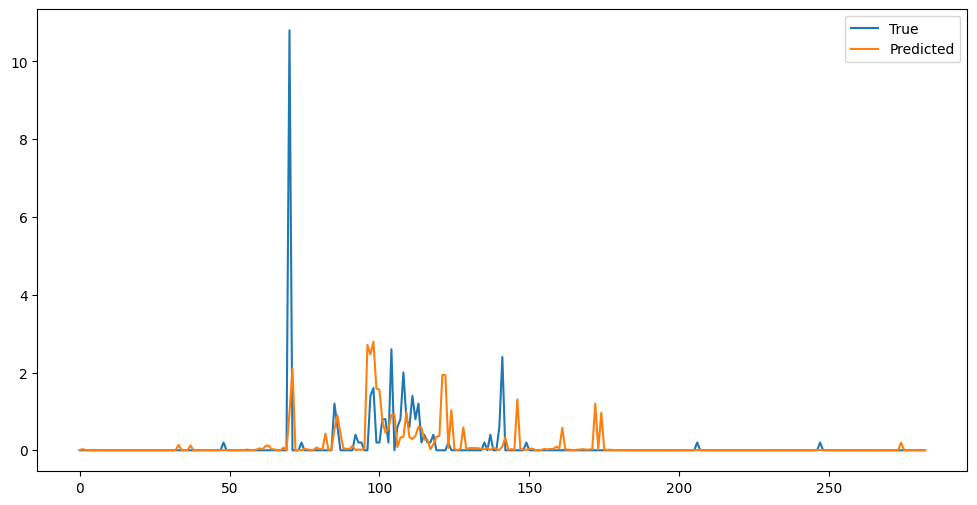

In [11]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test.reset_index(drop=True), label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()


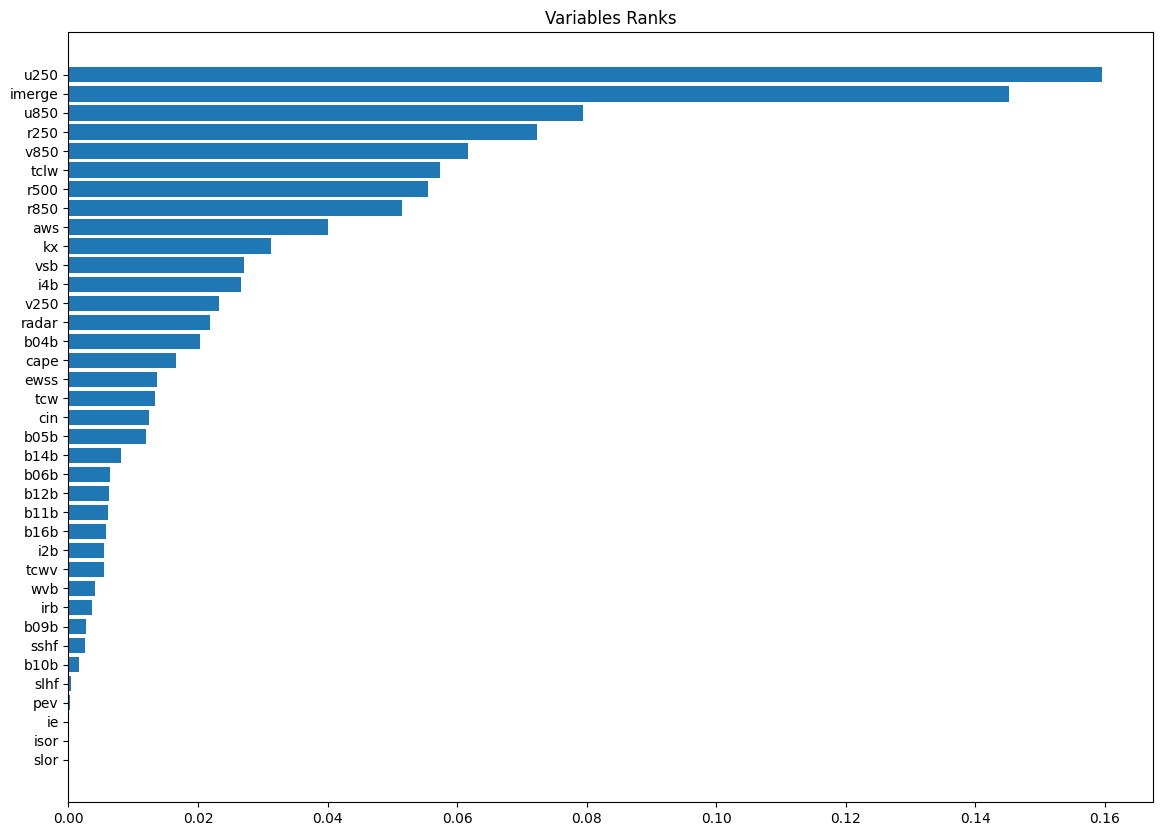

In [12]:
# Print feature importances
features = X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(14,10))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), features[indices])
plt.title("Variables Ranks")
plt.show()


In [15]:
# Print list of feature importances where importance > 0.05
important_features = []
for i in range(len(features)):
	if importances[i] > 0.04:
		important_features.append(features[i])

print(important_features)

['aws', 'imerge', 'tclw', 'r850', 'u850', 'r250', 'v850', 'r500', 'u250']
